In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import pathlib
import numpy as np

from pymdp.agent import Agent
from pymdp import utils, maths

In [2]:
from pymdp.envs.grid_world_2 import GridWorldCueEnv

In [3]:
# grid_dims = [5, 7] # dimensions of the grid (number of rows, number of columns)
# num_grid_points = np.prod(grid_dims) # total number of grid locations (rows X columns)

# # create a look-up table `loc_list` that maps linear indices to tuples of (y, x) coordinates 
# grid = np.arange(num_grid_points).reshape(grid_dims)
# it = np.nditer(grid, flags=["multi_index"])

# loc_list = []
# while not it.finished:
#     loc_list.append(it.multi_index)
#     it.iternext()

# # (y, x) coordinate of the first cue's location, and then a list of the (y, x) coordinates of the possible locations of the second cue, and their labels (`L1`, `L2`, ...)
# cue1_location = (2, 0)

# cue2_loc_names = ['L1', 'L2', 'L3', 'L4']
# cue2_locations = [(0, 2), (1, 3), (3, 3), (4, 2)]

# # names of the reward conditions and their locations
# reward_conditions = ["TOP", "BOTTOM"]
# reward_locations = [(1, 5), (3, 5)]


In [4]:
# # list of dimensionalities of the hidden states -- useful for creating generative model later on
# num_states = [num_grid_points, len(cue2_locations), len(reward_conditions)]

# # Names of the cue1 observation levels, the cue2 observation levels, and the reward observation levels
# cue1_names = ['Null'] + cue2_loc_names # signals for the possible Cue 2 locations, that only are seen when agent is visiting Cue 1
# cue2_names = ['Null', 'reward_on_top', 'reward_on_bottom']
# reward_names = ['Null', 'Cheese', 'Shock']

# num_obs = [num_grid_points, len(cue1_names), len(cue2_names), len(reward_names)]

In [5]:
my_env = GridWorldCueEnv(starting_loc = (0,0), cue1_loc = (2, 0), cue2 = 'L4', reward_condition = 'B')

Starting location is (0, 0), Reward condition is B, cue is located in L4


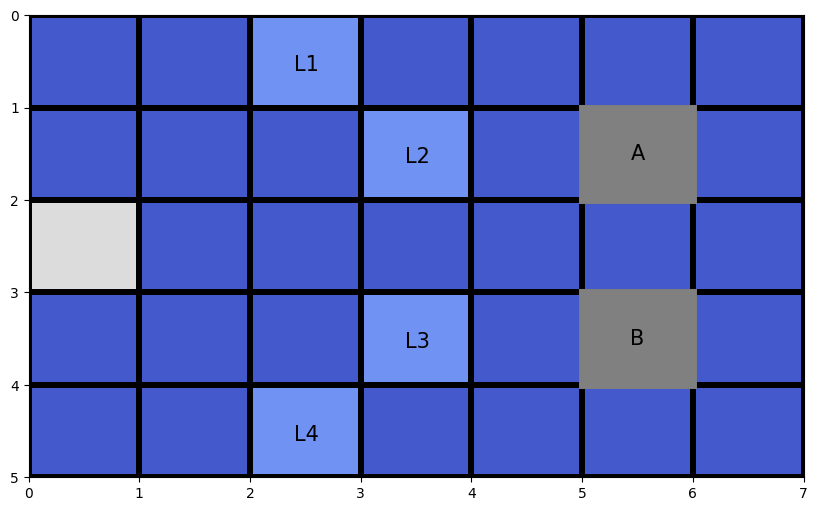

In [6]:
my_env.plot_empty_grid()

In [7]:
num_states = my_env.num_states
num_obs = my_env.num_obs
num_grid_points = my_env.num_grid_points
cue1_location = my_env.cue1_loc
cue2_locations = my_env.cue2_locations
loc_list = my_env.loc_list
reward_locations = my_env.reward_locations
grid_dims = my_env.grid_dims
cue1_names = my_env.cue1_names
cue2_names = my_env.cue2_names
reward_names = my_env.reward_names

### The observation model: **A** array
Now using `num_states` and `num_obs` we can initialize `A`, the observation model

In [8]:
A_m_shapes = [ [o_dim] + num_states for o_dim in num_obs] # list of shapes of modality-specific A[m] arrays
A = utils.obj_array_zeros(A_m_shapes) # initialize A array to an object array of all-zero subarrays

In [9]:
# make the location observation only depend on the location state (proprioceptive observation modality)
A[0] = np.tile(np.expand_dims(np.eye(num_grid_points), (-2, -1)), (1, 1, num_states[1], num_states[2]))

In [10]:
# make the cue1 observation depend on the location (being at cue1_location) and the true location of cue2
A[1][0,:,:,:] = 1.0 # default makes Null the most likely observation everywhere

# Make the Cue 1 signal depend on 1) being at the Cue 1 location and 2) the location of Cue 2
for i, cue_loc2_i in enumerate(cue2_locations):
    A[1][0,loc_list.index(cue1_location),i,:] = 0.0
    A[1][i+1,loc_list.index(cue1_location),i,:] = 1.0

In [11]:
# make the cue2 observation depend on the location (being at the correct cue2_location) and the reward condition
A[2][0,:,:,:] = 1.0 # default makes Null the most likely observation everywhere

for i, cue_loc2_i in enumerate(cue2_locations):

    # if the cue2-location is the one you're currently at, then you get a signal about where the reward is
    A[2][0,loc_list.index(cue_loc2_i),i,:] = 0.0 
    A[2][1,loc_list.index(cue_loc2_i),i,0] = 1.0
    A[2][2,loc_list.index(cue_loc2_i),i,1] = 1.0

In [12]:
# make the reward observation depend on the location (being at reward location) and the reward condition
A[3][0,:,:,:] = 1.0 # default makes Null the most likely observation everywhere

rew_top_idx = loc_list.index(reward_locations[0]) # linear index of the location of the "TOP" reward location
rew_bott_idx = loc_list.index(reward_locations[1]) # linear index of the location of the "BOTTOM" reward location

# fill out the contingencies when the agent is in the "TOP" reward location
A[3][0,rew_top_idx,:,:] = 0.0
A[3][1,rew_top_idx,:,0] = 1.0
A[3][2,rew_top_idx,:,1] = 1.0

# fill out the contingencies when the agent is in the "BOTTOM" reward location
A[3][0,rew_bott_idx,:,:] = 0.0
A[3][1,rew_bott_idx,:,1] = 1.0
A[3][2,rew_bott_idx,:,0] = 1.0

### The transition model: **B** array
To create the `B` array or transition model, we have to further specify `num_controls`, which like `num_states` / `num_obs` is a list, but this time of the dimensionalities of each *control factor*, which are the hidden state factors that are controllable by the agent. Uncontrollable hidden state factors can be encoded as control factors of dimension 1. Once `num_controls` is defined, we can then use it and `num_states` to specify the dimensionality of the `B` arrays. Recall that in `pymdp` hidden state factors are conditionally independent of eachother, meaning that each sub-array `B[f]` describes the dynamics of only a single hidden state factor, and its probabilistic dependence on both its own state (at the previous time) and the state of its corresponding control factor.

In the current grid world task, we will have the agent have the ability to make movements in the 4 cardinal directions (UP, DOWN, LEFT, RIGHT) as well as the option to stay in the same place (STAY). This means we will associate a single 5-dimensional control state factor with the first hidden state factor. 

*Note*: Make sure the indices of the `num_controls` variables "lines up" with those of `num_states`.

In [13]:
# initialize `num_controls`
num_controls = [5, 1, 1]

# initialize the shapes of each sub-array `B[f]`
B_f_shapes = [ [ns, ns, num_controls[f]] for f, ns in enumerate(num_states)]

# create the `B` array and fill it out
B = utils.obj_array_zeros(B_f_shapes)

In [14]:
actions = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]

# fill out `B[0]` using the 
for action_id, action_label in enumerate(actions):

  for curr_state, grid_location in enumerate(loc_list):

    y, x = grid_location

    if action_label == "UP":
      next_y = y - 1 if y > 0 else y 
      next_x = x
    elif action_label == "DOWN":
      next_y = y + 1 if y < (grid_dims[0]-1) else y 
      next_x = x
    elif action_label == "LEFT":
      next_x = x - 1 if x > 0 else x 
      next_y = y
    elif action_label == "RIGHT":
      next_x = x + 1 if x < (grid_dims[1]-1) else x 
      next_y = y
    elif action_label == "STAY":
      next_x = x
      next_y = y

    new_location = (next_y, next_x)
    next_state = loc_list.index(new_location)
    B[0][next_state, curr_state, action_id] = 1.0

In [15]:
B[1][:,:,0] = np.eye(num_states[1])
B[2][:,:,0] = np.eye(num_states[2])

### Prior preferences: the **C** vectors

Now we specify the agent's prior over observations, also known as the "prior preferences" or "goal vector." This is not technically a part of the same generative model used for inference of hidden states, but part of a special predictive generative model using for policy inference. 

Since the prior preferences are defined in `pymdp` as priors over observations, not states, so `C` will be an object array whose sub-arrays correspond to the priors over specific observation modalities, e.g `C[3]` encodes the prior preferences for different levels of the **Reward** observation modality.

In [16]:
C = utils.obj_array_zeros(num_obs)

C[3][1] = 2.0 # make the agent want to encounter the "Cheese" observation level
C[3][2] = -4.0 # make the agent not want to encounter the "Shock" observation level

### Prior over (initial) hidden states: the **D** vectors

Now we specify the agent's prior over initial hidden states, the `D` array. Since it's defined over the multi-factor hidden states in this case, `D` will be an object array whose sub-arrays correspond to the priors over specific hidden state factors, e.g `D[0]` encodes the prior beliefs over the initial location of the agent in the grid world.

In [17]:
D = utils.obj_array_uniform(num_states)
D[0] = utils.onehot(loc_list.index((0,0)), num_grid_points)

## Active Inference

In [18]:
my_agent = Agent(A = A, B = B, C = C, D = D, policy_len = 4)

loc_obs, cue1_obs, cue2_obs, reward_obs = my_env.reset()

Re-initialized location to (0, 0)


### Run an active inference loop over time
...saving the history of the rat's locations as you do so. Include some print statements if you want to see the output of the agent's choices as they unfold.

In [19]:
history_of_locs = [loc_obs]
obs = [loc_list.index(loc_obs), cue1_names.index(cue1_obs), cue2_names.index(cue2_obs), reward_names.index(reward_obs)]

T = 10 # number of total timesteps
# T = 30

for t in range(T):

    qs = my_agent.infer_states(obs)
    
    my_agent.infer_policies()
    chosen_action_id = my_agent.sample_action()

    movement_id = int(chosen_action_id[0])

    choice_action = actions[movement_id]

    print(f'Action at time {t}: {choice_action}')

    loc_obs, cue1_obs, cue2_obs, reward_obs = my_env.step(choice_action)

    obs = [loc_list.index(loc_obs), cue1_names.index(cue1_obs), cue2_names.index(cue2_obs), reward_names.index(reward_obs)]

    history_of_locs.append(loc_obs)

    print(f'Grid location at time {t}: {loc_obs}')

    print(f'Reward at time {t}: {reward_obs}')


Action at time 0: DOWN
Grid location at time 0: (1, 0)
Reward at time 0: Null
Action at time 1: DOWN
Grid location at time 1: (2, 0)
Reward at time 1: Null
Action at time 2: DOWN
Grid location at time 2: (3, 0)
Reward at time 2: Null
Action at time 3: RIGHT
Grid location at time 3: (3, 1)
Reward at time 3: Null
Action at time 4: DOWN
Grid location at time 4: (4, 1)
Reward at time 4: Null
Action at time 5: RIGHT
Grid location at time 5: (4, 2)
Reward at time 5: Null
Action at time 6: RIGHT
Grid location at time 6: (4, 3)
Reward at time 6: Null
Action at time 7: RIGHT
Grid location at time 7: (4, 4)
Reward at time 7: Null
Action at time 8: UP
Grid location at time 8: (3, 4)
Reward at time 8: Null
Action at time 9: RIGHT
Grid location at time 9: (3, 5)
Reward at time 9: Cheese


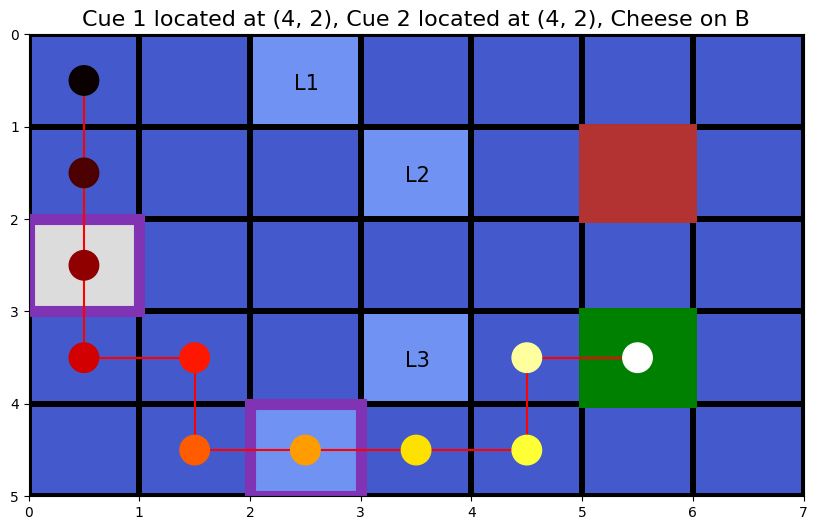

In [20]:
my_env.plot_movement(history_of_locs, T=T)